In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from glob import glob
from tqdm.auto import tqdm
import tensorflow as tf
from tensorflow.keras import layers, models, utils
from sklearn.model_selection import train_test_split
import imgaug as ia
import imgaug.augmenters as iaa

In [2]:
IMG_SIZE = 200
BATCH_SIZE = 32

all_class = ['normal', 'bacteria', 'virus']
class_map = {cls:i for i,cls in enumerate(all_class)}
class_map

{'normal': 0, 'bacteria': 1, 'virus': 2}

In [3]:
img_paths_train = glob('pneumonia-kaggle/train/*/*.jpeg')
img_paths_train, img_paths_val = train_test_split(img_paths_train, test_size=0.2)
len(img_paths_train), len(img_paths_val)

(4172, 1044)

In [4]:
class DataGenerator(utils.Sequence):
    def __init__(self, paths, batch_size, img_size, shuffle=True, aug=False):
        self.paths = paths
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.paths))
        all_class = ['normal', 'bacteria', 'virus']
        self.class_map = {cls:i for i,cls in enumerate(all_class)}
        self.num_classes = len(self.class_map)
        self.img_size = img_size
        self.aug = aug
        self.seq = iaa.Sequential([
            iaa.Fliplr(0.5),
            iaa.Affine(
                rotate = (-10, 10),
                shear = (-16, 16),
                scale = {'x' : (0.8, 1.2), 'y' : (0.8, 1.2)}
            )
        ])
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.paths) / self.batch_size))
    
    def __getitem__(self, batch_index):
        idxs = self.indexes[batch_index * self.batch_size : (batch_index + 1) * self.batch_size]
        batch_paths = [self.paths[i] for i in idxs]
        x,y = self.__data_generation(batch_paths)
        return x, y
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    def __data_generation(self, paths):
        x = np.empty((len(paths), self.img_size, self.img_size, 3), dtype=np.float32)
        y = np.empty(len(paths))
        for i, path in enumerate(paths):
            img = cv2.imread(path)[:,:,::-1]
            img = cv2.resize(img, (self.img_size, self.img_size))
            img = img / 255.
            cls = path.split(os.sep)[-2].lower()
            if cls == 'pneumonia':
                filename = path.split(os.sep)[-1]
                cls_pneumonia = filename.split('_')[1]
                cls_idx = class_map[cls_pneumonia]
            else:
                cls_idx = class_map[cls]
            x[i] = img
            y[i] = cls_idx
        y = tf.keras.utils.to_categorical(y, num_classes=self.num_classes)
        if self.aug:
            x = self.augmentation(x)
        return x, y

    def augmentation(self, imgs):
        return self.seq.augment_images(imgs)

In [5]:
gen_train = DataGenerator(img_paths_train, BATCH_SIZE, IMG_SIZE, shuffle=True, aug=True)
gen_val = DataGenerator(img_paths_val, BATCH_SIZE, IMG_SIZE, shuffle=False, aug=False)
len(gen_train), len(gen_val)

(131, 33)

2022-04-12 21:59:09.442407: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-04-12 21:59:09.468964: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-04-12 21:59:09.469453: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-04-12 21:59:09.470752: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

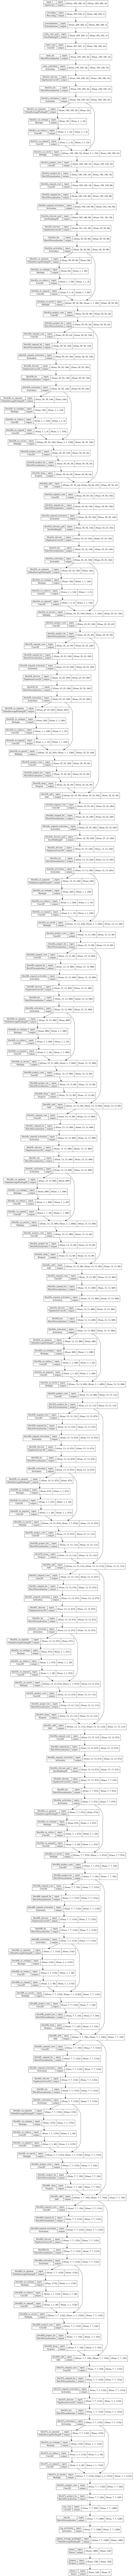

In [6]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False,
                                                  weights='imagenet',
                                                  input_shape=(IMG_SIZE, IMG_SIZE, 3))
for l in base_model.layers:
    l.trainable = False

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(3, activation='softmax')(x)

model = models.Model(base_model.input, x)
utils.plot_model(model, show_shapes=True)

In [7]:
model.compile(tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [9]:
model.fit(gen_train,
          epochs=100000,
          callbacks=[
              tf.keras.callbacks.EarlyStopping(patience=10),
              tf.keras.callbacks.ModelCheckpoint('./best.h5', save_best_only=True),
              tf.keras.callbacks.ModelCheckpoint('./last.h5', save_best_only=False),
              tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.3)
          ],
          validation_data=gen_val)

Epoch 1/100000


2022-04-12 22:06:46.647980: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8302


  1/131 [..............................] - ETA: 15:50 - loss: 1.1351 - accuracy: 0.3750

2022-04-12 22:06:49.283075: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


131/131 [==============================] - 68s 468ms/step - loss: 1.0680 - accuracy: 0.4765 - val_loss: 1.0595 - val_accuracy: 0.4713 - lr: 0.0010
Epoch 2/100000
131/131 [==============================] - 58s 442ms/step - loss: 1.0610 - accuracy: 0.4887 - val_loss: 1.0595 - val_accuracy: 0.4713 - lr: 0.0010
Epoch 3/100000
131/131 [==============================] - 58s 443ms/step - loss: 1.0582 - accuracy: 0.4885 - val_loss: 1.0582 - val_accuracy: 0.4713 - lr: 0.0010
Epoch 4/100000
131/131 [==============================] - 56s 431ms/step - loss: 1.0571 - accuracy: 0.4885 - val_loss: 1.0588 - val_accuracy: 0.4713 - lr: 0.0010
Epoch 5/100000
131/131 [==============================] - 52s 398ms/step - loss: 1.0554 - accuracy: 0.4885 - val_loss: 1.0584 - val_accuracy: 0.4713 - lr: 0.0010
Epoch 6/100000
131/131 [==============================] - 52s 401ms/step - loss: 1.0542 - accuracy: 0.4885 - val_loss: 1.0582 - val_accuracy: 0.4713 - lr: 0.0010
Epoch 7/100000
131/131 [===================

KeyboardInterrupt: 